In [3]:
 %reload_ext autoreload

In [1]:
!python3 test.py --head_type single_3FC \
    --ckpt experiment/inceptionv3/11/narrow/single_3FC/resize+aug/head_ep4_vloss0.40_plcc0.60_srcc0.59_acc0.77_.pth \
    --feature_type narrow --resize --augment

1246it [01:33, 13.39it/s]
Test mse-0.37606753792799114, acc-0.766910879164994, srcc-0.6298137069271204, plcc-0.6409744748920765


In [2]:
%autoreload

from model.base import Base
from model.head import Head
import torch
import h5py
import numpy as np
import os
from utils import build_h5,extract_features, get_model_from_ckpt,train,eval,lr_rescheduler, makedirs,save_model,logging
from torch.optim import Adam
import gc
from dataloader import get_dataloader
from model.finetune_model import Fmodel
from torchsummary import summary
torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

hard_dp = False
if hard_dp:
    dropout = [0.5,0.5,0.75]
else:
    dropout = [0.25,0.25,0.5]

base_model_type = 'inceptionv3'
num_level = 11
feature_type = 'narrow'
head_type = 'multi_3FC'
if feature_type == 'wide':
    head_type = 'pool_3FC'
    
root = './experiment/'
resize = True
augment = False
n_aug = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_folder,fea_folder = makedirs(root,base_model_type,num_level,feature_type,head_type,resize,augment,hard_dp)
h5_paths = [os.path.join(os.path.split(fea_folder)[0] if split!='train' else fea_folder, split + '_fea.h5') for split in ['train', 'val', 'test']]
train_batch_size = 1
fealoaders = get_dataloader(data_type='fea', head_type = head_type, resize = resize, augment= augment, h5_paths = h5_paths, batch_size = train_batch_size)

In [4]:
a = iter(fealoaders[0])
b,c = a.next()
b = b.detach().numpy()
bs = 1
for i in range(len(fealoaders[0].dataset)):
    c,d = a.next()
    c = c.detach().numpy()
    if (c==a).all():
        print('found')
    


In [9]:
%autoreload
from dataloader import get_dataloader
extract_batch_size = 1

imgloaders = get_dataloader(data_type='img',resize=resize,augment=augment,finetune=True,\
                            batch_size = extract_batch_size, head_type = head_type)
a = iter(imgloaders[0])
b,c = a.next()


1000.jpg MOS    5.58
Name: 1000, dtype: float64
10002.jpg MOS    4.243386
Name: 10002, dtype: float64
10000.jpg MOS    5.053763
Name: 10000, dtype: float64
10005.jpg MOS    5.411111
Name: 10005, dtype: float64
10003.jpg MOS    6.068182
Name: 10003, dtype: float64


In [12]:
df.loc[10002]

MOS    4.243386
Name: 10002, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

# %autoreload
# from dataloader import ImgDataset
# a = ImgDataset('./data/', 'train' , True, True, False)
# b = iter(a)
# feature, label = next(b)


1000.jpg


'for batch, (feature, label) in enumerate(imgloaders[2]):\n    plt.imshow(np.moveaxis(feature[0].numpy(),0,-1))\n    plt.show()\n    print(label[0])'

10007.jpg


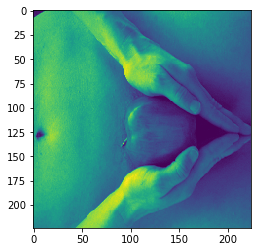

tensor(5.8876, dtype=torch.float64)


In [ ]:
import numpy as np
feature, label = next(b)
plt.imshow(np.moveaxis(feature[0].numpy(),0,-1))
plt.show()
print(label[0])

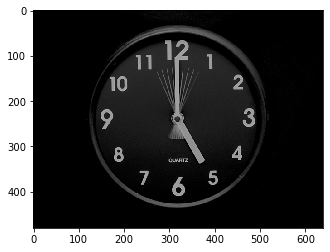

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
a = Image.open('./imgs/images/1006.jpg').convert("RGB")
plt.imshow(a)
plt.show()

In [5]:
import pandas as pd

df = pd.read_csv('./data/AVA.txt', header = None, delimiter = '\s+')
df.drop(columns = [0,12,13,14],inplace=True)
df['count'] = df.iloc[:,1:].sum(axis=1)
for i in range(2,12):
    df[i] = df[i]*(i-1)
df['MOS'] = df.iloc[:,1:-1].sum(axis=1)/df['count']
df.rename(columns = {1:'img'},inplace=True)
df.loc[(df.img==954113)]
df.set_index('img',inplace=True)
df.drop(columns = df.columns[:-1],inplace=True)
#df.to_csv('./data/label.csv')

In [ ]:
df.loc[df.MOS == df.MOS.max()]
df.loc[900]

MOS    5.688776
Name: 900, dtype: float64

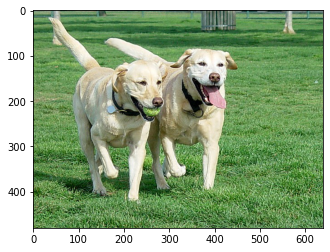

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open('/content/images/900.jpg'))
plt.show()

In [37]:
%autoreload

from model.base import Base
from model.head import Head
import torch
import h5py
import numpy as np
import os
from utils import build_h5,extract_features, get_model_from_ckpt,train,eval,lr_rescheduler, makedirs,save_model,logging
from torch.optim import Adam
import gc
from dataloader import get_dataloader
import matplotlib.pyplot as plt
from PIL import Image
import os
from model.finetune_model import Fmodel
import pandas as pd
torch.cuda.set_per_process_memory_fraction(0.1, 0)

hard_dp = False
if hard_dp:
    dropout = [0.5,0.5,0.75]
else:
    dropout = [0.25,0.25,0.5]

base_model_type = 'inceptionv3'
num_level = 11
feature_type = 'narrow'
head_type = 'multi_3FC'
if feature_type == 'wide':
    head_type = 'pool_3FC'
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bmodel = Base(model = base_model_type)

head = Head(head_type,bmodel.channel_size,dropout)
head,_,_,_,_,_ = get_model_from_ckpt(model = head,
    ckpt = 'experiment/inceptionv3/11/narrow/multi_3FC/resize/head_ep30_vloss0.47_plcc0.62_srcc0.60_acc0.72_.pth')
fmodel = Fmodel(base_model_type,feature_type, head, bmodel)
fmodel.to(device)
fmodel.eval()

df = pd.read_csv('./data/AVA_data_official_test.csv').set_index('image_name')


In [38]:
import torchvision.transforms as T
from torchvision.transforms.functional import five_crop,crop,resize,hflip,normalize

a =  771082
img = Image.open(f'/content/images/{a}.jpg')
label = df.loc[f'{a}.jpg'].MOS

# plt.imshow(img)
# plt.show()

if len(img.size)==2:
    img = img.convert('RGB')
img = T.ToTensor()(img)
img = normalize(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = torch.unsqueeze(img,0)
img =img.to(device)
pred = fmodel(img)
print('pred: ', pred, ' , label: ', label)

narrow
pred:  tensor([[4.7594]], device='cuda:0', grad_fn=<AddmmBackward>)  , label:  5.24848484848


In [1]:
import pandas as pd

mode = 'val'
df = pd.read_csv('./data/AVA_data_official_test.csv')
df.loc[df.set=='test'].head(10)



,Unnamed: 0,1,2,3,4,5,6,7,8,9,10,tag1,tag2,challenge_id,MOS,image_name,MLS,set,width,height
38,38,0,0,1,5,18,39,31,22,9,7,2,14,1396,6.750000,954013.jpg,6,test,800.0,514.0
73,73,0,1,6,13,52,45,4,2,1,0,20,61,1396,5.282258,953630.jpg,5,test,574.0,780.0
131,131,1,2,3,13,66,58,18,7,2,1,14,53,1004,5.578947,771289.jpg,5,test,720.0,480.0
141,141,0,1,6,35,64,39,14,3,0,3,20,0,1004,5.248485,771082.jpg,5,test,709.0,468.0
145,145,5,3,15,31,56,31,10,6,2,1,14,0,1004,4.950000,771392.jpg,5,test,485.0,720.0
146,146,0,2,2,11,64,58,16,12,5,1,18,0,1004,5.760234,771538.jpg,5,test,720.0,538.0
150,150,0,0,1,13,56,59,25,6,4,2,11,18,1004,5.831325,771346.jpg,6,test,720.0,720.0
187,187,0,2,6,30,69,38,8,2,2,0,20,45,1004,5.127389,770684.jpg,5,test,720.0,480.0
197,197,0,0,1,7,36,60,37,20,7,8,20,45,1004,6.437500,771602.jpg,6,test,720.0,577.0
198,198,3,7,32,53,55,15,2,4,0,1,15,19,1004,4.337209,771404.jpg,5,test,720.0,479.0


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open('/content/images/954013.jpg'))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/images/954013.jpg'

In [ ]:
!python3 train_head.py --head_type pool_3FC --feature_type wide

In [2]:
df['set'] = df['set'].map({'training':'train','validation':'val','test':'test'})
df.to_csv('./data/AVA_data_official_test.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10,tag1,tag2,challenge_id,MOS,image_name,MLS,set,width,height
0,0,0,0,5,32,50,23,10,3,1,22,0,1396,6.112903,953417.jpg,6,train,781.0,699.0
1,0,3,2,3,13,40,35,21,8,3,20,53,1396,6.593750,953777.jpg,6,train,550.0,800.0
2,0,2,3,9,35,50,20,5,2,2,0,0,1396,5.796875,953756.jpg,6,train,800.0,594.0
3,0,1,7,26,56,23,6,1,0,2,0,0,1396,5.040984,954195.jpg,5,train,587.0,674.0
4,0,1,4,5,33,50,17,9,3,2,21,28,1396,5.943548,953903.jpg,6,train,800.0,533.0
